In [ ]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!kaggle -v

Kaggle API 1.5.4


In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 98% 391M/398M [00:03<00:00, 207MB/s]
100% 398M/398M [00:03<00:00, 122MB/s]


In [ ]:
!unzip -q 'face-mask-detection.zip'

In [ ]:
# Build from source
!pip install pyyaml==5.1 pycocotools>=2.0.2 Pillow>=7.1 termcolor>=1.1
!pip3 install --upgrade Pillow
!pip install imgaug==0.2.9
!pip install --upgrade albumentations
!python -m pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [ ]:
import xml.etree.ElementTree as ET
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    return root

# Create loading dataset

Provide compatible format

In [ ]:
import os
from detectron2.structures import BoxMode

el = read_content('/content/annotations/maksssksksss0.xml')


categories = ['with_mask', 'without_mask', 'mask_weared_incorrect']


def load_dataset():
    dataset_dict = []
    unique_id = 0
    for idx, el in enumerate(os.listdir('./annotations')):
        el = read_content('./annotations/' + el)
        dataset = {}

        img = el.find('filename')
        dataset['file_name'] = "images/" + img.text
        dataset['width'] = int(el.find('size/width').text)
        dataset['height'] = int(el.find('size/height').text)
        dataset['id'] = idx
        
        anns = []
        for obj in el.iter('object'):
            ann = {}
            xmin = float(obj.find('bndbox/xmin').text)
            xmax = float(obj.find('bndbox/xmax').text)
            ymin = float(obj.find('bndbox/ymin').text)
            ymax = float(obj.find('bndbox/ymax').text)
            ann['bbox'] = [xmin, ymin, xmax, ymax]
            ann['bbox_mode'] = BoxMode.XYXY_ABS
            ann['polygon'] = [ann['bbox']]
            ann['category_id'] = categories.index(obj.find('name').text)
            ann['id'] = unique_id
            anns.append(ann)
        dataset['annotations'] = anns
        dataset_dict.append(dataset)
    return dataset_dict

In [ ]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog

name = "mask_train"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except Exception as e:
    pass
finally:
    DatasetCatalog.register(name, lambda: load_dataset())
    MetadataCatalog.get(name).set(thing_classes=categories)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
 
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("mask_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.BASE_LR = 0.002  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 3000  #No. of iterations
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.RETINANET.NUM_CLASSES = 3 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/18 08:24:12 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

# Inference

In [ ]:
from detectron2.engine import DefaultPredictor

# cfg already contains everything we've set previously. 
# Now we changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
# Set Threshold for nms and score to avoid too much bounding box produced.
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.6
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

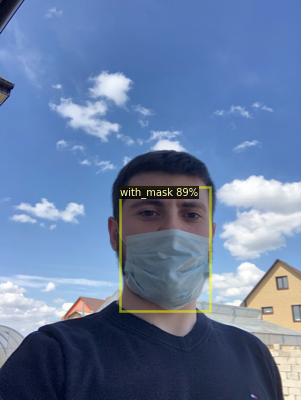

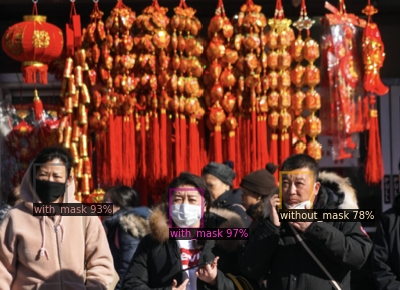

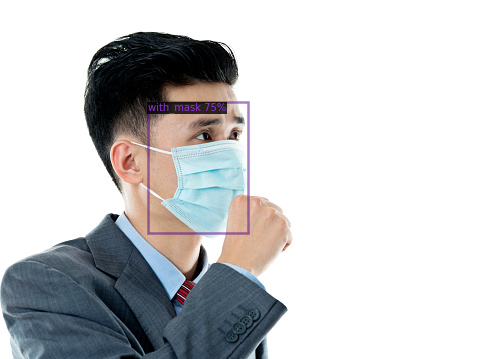

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import random
from google.colab.patches import cv2_imshow
import cv2

board_metadata = MetadataCatalog.get("mask_train")
dataset_dicts = load_dataset()

# Pick 3 random images from dataset_dict
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])